In [421]:
from IPython.display import display, clear_output
import numpy as np
import torch
import sys
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split, dataset
import pandas as pd
import random

In [422]:
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")
sys.path.append("../../../../")

In [423]:
from lib.util import MHPI, calculate_rmse, calculate_r2, count_parameters, calculate_metrics
from lib.utiltools import loss_live_plot, GaussianRandomFieldGenerator, generate_batch_parameters, AutomaticWeightedLoss, plot_losses_from_excel
from lib.DerivativeComputer import batchJacobian_AD

In [424]:
from models.Polynomial_Neural_Operator import PNO1DTime
from models.Convolutional_Neural_Operators2d import CNO1DTime
from models.DeepONet2d import DNO1DTime
from models.FNO_2d import FNO2d
from models.WNO_2d import WNO2d
from models.MultiWaveletConv_2d import MWNO2d

In [425]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../"


In [426]:
Operator = 'FNO'    # PMO, CNO, DeepONet
enable_ig_loss = True
label = 'SC_' + Operator if enable_ig_loss else Operator

In [427]:
state_size, parameter_size = 1, 62

In [441]:
train_sample = 400
eval_sample = 150
test_sample = 150
n_zone = 20
# Set Mode based on IG loss
Mode = Operator + f"_Data_{'IG_' if enable_ig_loss else ''}zoned_33_{n_zone}_{train_sample}"

# Load dataset
filename = f'datasets/main_dataset_zones_3_{n_zone}.pt'
dataset = torch.load(PATH + filename, weights_only=False)

# Set seeds
random.seed(42)
torch.manual_seed(42)

# Check dataset size
total_samples = train_sample + eval_sample + test_sample
if len(dataset) < total_samples:
    raise ValueError("Dataset too small for desired splits")

# Create splits
indices = torch.randperm(len(dataset))
train_indices = indices[:train_sample]
eval_indices = indices[train_sample:train_sample + eval_sample]
test_indices = indices[train_sample + eval_sample:total_samples]
rest_indices = indices[total_samples:]  # All remaining data

# Create data loaders
train_data = torch.utils.data.Subset(dataset, train_indices)
eval_data = torch.utils.data.Subset(dataset, eval_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)
rest_data = torch.utils.data.Subset(dataset, rest_indices)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
eval_loader = DataLoader(eval_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
rest_loader = DataLoader(rest_data, batch_size=1, shuffle=False)

# Print dataset splits information
print(f"Dataset splits:")
print(f"Total dataset size: {len(dataset)}")
print(f"Training samples: {len(train_data)}")
print(f"Evaluation samples: {len(eval_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Rest samples: {len(rest_data)}")

Dataset splits:
Total dataset size: 1000
Training samples: 400
Evaluation samples: 150
Test samples: 150
Rest samples: 300


In [429]:
dataset.tensors[-1].shape, dataset.tensors[0].shape

(torch.Size([1000, 40, 30, 62, 1]), torch.Size([1000, 62]))

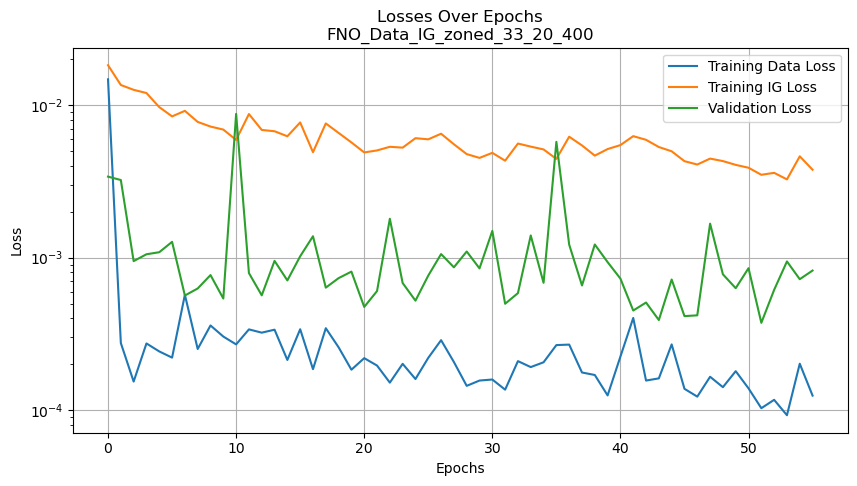

In [442]:
plot_losses_from_excel(PATH + 'loss/' + f'losses_data_{Mode}.xlsx', lable=Mode)

In [431]:
L = 1.0
dx = 0.025
nx = int(L / dx)
x = torch.linspace(0, L, nx, device=device)

In [432]:
t0 = 0.0
t_end = 0.2
steps_solve = 210
step_save = 30
T_in = 5
T_out = step_save - T_in

In [433]:
checkpoint = torch.load(PATH + 'saved_models/' + Mode + '_saved_model.pth', weights_only=False)

In [434]:
if Operator == 'CNO':
    width = checkpoint['width']
    depth = checkpoint['depth']
    kernel_size = checkpoint['kernel_size']
    model = CNO1DTime(nx, T_in, T_out, state_size, parameter_size, width, depth, kernel_size).to(device)
elif Operator == 'PNO':
    poly_degree = checkpoint['poly_degree']
    width = checkpoint['width']
    depth = checkpoint['depth']
    model = PNO1DTime(nx, T_in, T_out, state_size, parameter_size, poly_degree, width, depth).to(device)
elif Operator =='DeepONet':
    branch_layers = checkpoint['branch_layers']
    trunk_layers = checkpoint['trunk_layers']
    model = DNO1DTime(nx, T_in, T_out, state_size, parameter_size, branch_layers, trunk_layers).to(device)
elif Operator =='FNO':
    modes1 = checkpoint['modes1']
    modes2 = checkpoint['modes2']
    width = checkpoint['width']
    model = FNO2d(modes1, modes2,  width, T_in, T_out, parameter_size=parameter_size, state_size=1).to(device)
elif Operator =='WNO':
    levels = checkpoint['levels']
    size = checkpoint['size']
    width = checkpoint['width']
    model = WNO2d(levels=levels, size=[nx, nx], width=width, T_in=T_in, T_out=T_out, state_size=1, parameter_size=parameter_size).to(device)    
elif Operator =='MWNO':
    levels = checkpoint['levels']
    size = checkpoint['size']
    width = checkpoint['width']
    model = MWNO2d(levels=levels, size=[nx, nx], width=width, T_in=T_in, T_out=T_out, state_size=1, parameter_size=parameter_size).to(device)

In [435]:
model.load_state_dict(checkpoint['model_state_dict'])
print(f'{label}: {count_parameters(model)}')


SC_FNO: 108297


In [436]:
U_pred_list, du_dp_list, batch_u_out_list, du_dparam_true_list = [], [], [], []
model.eval()  # Set the model to evaluation mode.

for batch_data in test_loader:
    batch_data_1 = [item.to(device) for item in batch_data]
    batch_parameters, batch_u, du_dparam_true = batch_data_1
    batch_u_in, batch_u_out = batch_u[..., :T_in, :], batch_u[..., T_in:, :]
    
    batch_size_ = batch_parameters.shape[0]
    batch_parameters.requires_grad_(True)        
    
    U_in = batch_u_in
    if Operator =='FNO' or Operator == 'WNO' or Operator == 'MWNO':
        t_tensor_ = torch.linspace(t0, t_end, step_save)[T_in:].unsqueeze(0).repeat(batch_size_, 1).to(device)
        x_tensor_ = torch.linspace(0, L, nx).unsqueeze(0).repeat(batch_size_, 1).to(device)
        U_pred = model(U_in, x_tensor_, t_tensor_, batch_parameters)
    else:
        U_pred = model(U_in, batch_parameters)
    du_dp = torch.zeros(batch_size_, nx, T_out, model.parameter_size, model.state_size).to(device)
    
    for i in range(model.state_size):
        state_tensor = U_pred[..., i]
        Jacobian = batchJacobian_AD(state_tensor.reshape(batch_size_, nx * T_out), batch_parameters, graphed=False, batchx=True)
        du_dp[..., i] = Jacobian.reshape(batch_size_, nx, T_out, model.parameter_size)
    
    torch.cuda.empty_cache()
    U_pred_list.append(U_pred.detach())    
    du_dp_list.append(du_dp[:, :, :, :, :].detach())
    batch_u_out_list.append(batch_u_out.detach())
    du_dparam_true_list.append(du_dparam_true)

U_pred = torch.cat(U_pred_list, dim=0)
du_dp = torch.cat(du_dp_list, dim=0)
batch_u_out = torch.cat(batch_u_out_list, dim=0)
du_dparam_true = torch.cat(du_dparam_true_list, dim=0)

In [437]:
du_dparam_true.max(), du_dp.max()

(tensor(19.8212, device='cuda:0'), tensor(17.1846, device='cuda:0'))

In [438]:
RMSE_Grads = torch.zeros(parameter_size)
R2_Grads = torch.zeros(parameter_size)  
L2_Grads = torch.zeros(parameter_size)
RelL2_Grads = torch.zeros(parameter_size) 
MaxL1_Grads = torch.zeros(parameter_size)

for i in range(parameter_size):
   predictions = du_dp[:, :, :, i, 0].cpu().detach()
   true_values = du_dparam_true[:, :, T_in:, i, 0].cpu().detach()
   RMSE_Grads[i], R2_Grads[i], L2_Grads[i], RelL2_Grads[i], MaxL1_Grads[i] = calculate_metrics(predictions, true_values)

RMSE_U, R2_U, L2_U, RelL2_U, MaxL1_U = calculate_metrics(U_pred, batch_u_out)

# Calculate mean metrics for Jacobian
mean_R2 = torch.mean(R2_Grads)
mean_RMSE = torch.mean(RMSE_Grads)
mean_L2 = torch.mean(L2_Grads)
mean_RelL2 = torch.mean(RelL2_Grads)
mean_MaxL1 = torch.mean(MaxL1_Grads)

print(f"\n{'='*50}")
print(f"Mode: {Mode}")
print(f"{'='*50}")

print("\nState Value Metrics:")
print(f"{'='*20}")
print(f"R²      : {R2_U:.5f}")
print(f"RMSE    : {RMSE_U:.5f}")
print(f"L2      : {L2_U:.5f}")
print(f"Rel L2  : {RelL2_U:.5f}")
print(f"Max L1  : {MaxL1_U:.5f}")

print("\nMean Jacobian Metrics:")
print(f"{'='*20}")
print(f"R²      : {mean_R2:.5f}")
print(f"RMSE    : {mean_RMSE:.5f}")
print(f"L2      : {mean_L2:.5f}")
print(f"Rel L2  : {mean_RelL2:.5f}")
print(f"Max L1  : {mean_MaxL1:.5f}")

print("\nJacobian Metrics by Parameter:")
print(f"{'='*20}")
for i in range(parameter_size):
   print(f"\nParameter {i+1}:")
   print(f"R²      : {R2_Grads[i]:.5f}")
   print(f"RMSE    : {RMSE_Grads[i]:.5f}")
   print(f"L2      : {L2_Grads[i]:.5f}")
   print(f"Rel L2  : {RelL2_Grads[i]:.5f}")
   print(f"Max L1  : {MaxL1_Grads[i]:.5f}")
print(f"\n{'='*50}\n")


Mode: FNO_Data_IG_zoned_3_20_400

State Value Metrics:
R²      : 0.99123
RMSE    : 0.02211
L2      : 8.56275
Rel L2  : 0.04245
Max L1  : 0.23665

Mean Jacobian Metrics:
R²      : 0.37336
RMSE    : 0.03390
L2      : 13.13087
Rel L2  : 0.70024
Max L1  : 0.82418

Jacobian Metrics by Parameter:

Parameter 1:
R²      : 0.97366
RMSE    : 0.20829
L2      : 80.67021
Rel L2  : 0.15281
Max L1  : 3.24334

Parameter 2:
R²      : 0.91127
RMSE    : 0.13263
L2      : 51.36693
Rel L2  : 0.28308
Max L1  : 3.32959

Parameter 3:
R²      : 0.52873
RMSE    : 0.10547
L2      : 40.84845
Rel L2  : 0.68512
Max L1  : 2.22123

Parameter 4:
R²      : 0.54863
RMSE    : 0.11397
L2      : 44.13889
Rel L2  : 0.64550
Max L1  : 2.26514

Parameter 5:
R²      : 0.53075
RMSE    : 0.07419
L2      : 28.73267
Rel L2  : 0.64614
Max L1  : 1.01006

Parameter 6:
R²      : 0.57858
RMSE    : 0.07183
L2      : 27.81848
Rel L2  : 0.62056
Max L1  : 2.79381

Parameter 7:
R²      : 0.53802
RMSE    : 0.07290
L2      : 28.23528
Rel L2  

In [ ]:

'''
Parametric Allen-Cahn Equation:
∂u/∂t = ϵ(x)∂²u/∂x² + α(x)u - β(x)u³

Parameters:
ϵ(x): Diffusion coefficient (spatially varying)
α(x): Linear term coefficient (spatially varying)
β(x): Cubic term coefficient (spatially varying)

Initial Condition:
u(x,0) = A*tanh(kx)

Boundary Conditions: Periodic, such that u(0, t) = u(L, t)
Spatial Domain: x ∈ [0, 1]
Temporal Domain: t ∈ [0, T]
'''


==================================================
Mode: FNO_Data_IG_zoned_3_1_100
==================================================

State Value Metrics:
====================
R²      : 0.99882
RMSE    : 0.00777
L2      : 3.00820
Rel L2  : 0.01513
Max L1  : 0.21255

Mean Jacobian Metrics:
====================
R²      : 0.99298
RMSE    : 0.01560
L2      : 6.04167
Rel L2  : 0.04860
Max L1  : 0.41201

==================================================
Mode: FNO_Data_zoned_3_1_100
==================================================

State Value Metrics:
====================
R²      : 0.99782
RMSE    : 0.01055
L2      : 4.08695
Rel L2  : 0.02056
Max L1  : 0.03611

Mean Jacobian Metrics:
====================
R²      : -5.83739
RMSE    : 0.34707
L2      : 134.41869
Rel L2  : 0.58305
Max L1  : 2.82265

